In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution,plot_histogram

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
# Initialize the Qiskit Runtime Service
from test_utils import read_account_file

In [2]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [3]:
marked_states = ["0000","0001"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

C:\Users\karim\AppData\Local\Temp\ipykernel_16824\2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


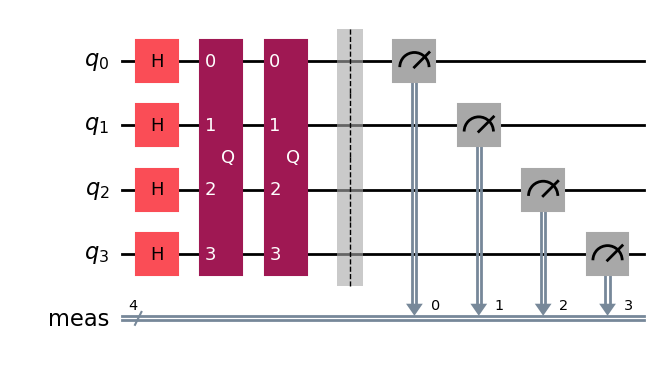

In [4]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [7]:
account = read_account_file('account_info.conf')
service = QiskitRuntimeService(channel="ibm_cloud", instance=account['instance'], token=account['token'])
backend = service.least_busy()
print(f"Using backend: {backend.name}")

Using backend: ibm_torino


In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")  
# Create a sampler instance
sampler = Sampler(mode=backend)
# Sample the transpiled circuit
job = sampler.run([circuit_isa], shots=1024)
print(f"Job ID: {job.job_id()}")

Job ID: d1h5ee5qbivc73edqcp0


In [12]:
job = service.job('d1h5ee5qbivc73edqcp0')

result = job.result()
#print(f"{result[0].data}")
# Get the counts (measurement results)
counts = result[0].data.meas.get_counts()

# Print the results
print("Measurement results:", counts) 
# Optionally, visualize the results
plot_histogram(counts).show()

Measurement results: {'0010': 72, '1011': 77, '0111': 67, '1001': 60, '0110': 53, '0001': 84, '0000': 83, '1000': 57, '1111': 55, '1110': 36, '0100': 72, '0011': 93, '0101': 58, '1010': 61, '1101': 44, '1100': 52}


C:\Users\karim\AppData\Local\Temp\ipykernel_16824\2614333530.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts).show()
